### 1.几何布朗运动

1.1 几何布朗运动模拟

几何布朗运动（Geometric Brownian Motion, GBM）的数学公式为：

$$ dS_t = \mu S_t dt + \sigma S_t dz $$

$$ \frac{dS_t}{S_t} = \mu  dt + \sigma  dz $$


$$ \Delta S_t = \mu S_{t-1} \Delta t + \sigma S_{t-1}  \epsilon \sqrt{\Delta t} $$

$$  S_t-S_{t-1} = \mu S_{t-1} \Delta t + \sigma S_{t-1}  \epsilon \sqrt{\Delta t} $$

$$  S_t = S_{t-1}+ \mu S_{t-1} \Delta t + \sigma S_{t-1}  \epsilon \sqrt{\Delta t} $$




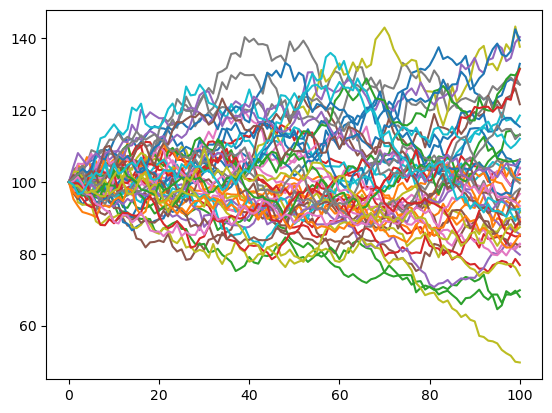

In [4]:
import numpy as np
import matplotlib.pyplot as plt


#  定义几何布朗运动函数
def geo_brownian(steps, paths, T, S0, u, sigma):
    dt = T / steps  # 求出dt
    S_path = np.zeros((steps + 1, paths))  # 创建一个矩阵，用来准备储存模拟情况
    S_path[0] = S0  # 起点设置,将第0行设置为S0
    rn = np.random.standard_normal(
        S_path.shape
    )  # 创建一个与 S_path 形状相同的二维数组，其中包含标准正态分布（均值为0，标准差为1）的随机数
    for step in range(1, steps + 1):
        S_path[step] = (
            S_path[step - 1]
            + u * S_path[step - 1] * dt
            + sigma * S_path[step - 1] * rn[step - 1] * np.sqrt(dt)
        )
    plt.plot(S_path[:, :])
    plt.show()
    return S_path


S_path = geo_brownian(steps=100, paths=50, T=1, S0=100, u=0.03, sigma=0.2)

1.2 解析解形式的几何布朗运动模拟
$$
dS_t = \mu S_t dt + \sigma S_t dz 
$$
$$
d(\ln S_t) = \left( \mu - \frac{1}{2} \sigma^2 \right) \, dt + \sigma \, dz
$$
$$
S_t = S_0 e^{ \left( \mu - \frac{1}{2} \sigma^2 \right) t + \sigma \epsilon \sqrt{t} }
$$

$$
S_t = S_{t-1} e^{ \left( \mu - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \epsilon \sqrt{\Delta t} }
$$

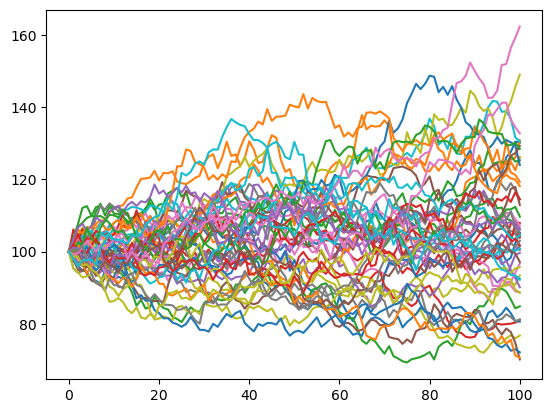

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#  定义几何布朗运动函数
def geo_brownian(steps, paths, T, S0, u, sigma):
    dt = T / steps  # 求出dt
    S_path = np.zeros((steps + 1, paths))  # 创建一个矩阵，用来准备储存模拟情况
    S_path[0] = S0  # 起点设置,将第0行设置为S0
    rn = np.random.standard_normal(
        S_path.shape
    )  # 创建一个与 S_path 形状相同的二维数组，其中包含标准正态分布（均值为0，标准差为1）的随机数
    for step in range(1, steps + 1):
        S_path[step] = S_path[step - 1] * np.exp(
            (u - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rn[step]
        )  # 逐步更新广义布朗运动的路径
    plt.plot(S_path[:, :])
    plt.show()
    return S_path


S_path = geo_brownian(steps=100, paths=50, T=1, S0=100, u=0.03, sigma=0.2)

### 2.蒙特卡洛欧式期权定价及与BSM定价的比较

蒙特卡洛期权定价的基本思路是根据衍生品价值就是未来现金流现值的期望这一基本原则，按照具体的随机过程，模拟出大量的路径，在每条路径分别计算衍生品的现金流现值，最后求期望可得定价。

具体步骤如下：

[1]模拟价格路径：使用几何布朗运动模型模拟标的资产的价格路径：
$$dS = \mu S \, dt + \sigma S \, dz$$
其中，$S$ 是标的资产价格，$\mu$ 是漂移率，$\sigma$ 是波动率，$dz$ 是一个标准布朗运动。

[2]生成随机数：利用正态分布的随机数生成器，模拟大量标的资产价格路径。这些路径反映了从当前时刻到期权到期日标的资产价格的可能演变。

[3]计算每条路径的期权价值：对于每条模拟路径，计算期权在到期时的收益。例如，对于欧式看涨期权，收益为：$$C_T = \max(S_T - K, 0)$$其中，$C_T$ 是期权到期时的价值，$S_T$ 是模拟的标的资产到期价格，$K$ 是执行价格。

[4]现值化未来现金流：将每条路径上的期权到期价值使用连续复利折现到当前时刻。折现因子为：$$PV = C_T e^{-rT}$$其中，$r$ 是连续复利的无风险利率，$T$ 是时间期限。

[5]求取期望值：对所有模拟路径的折现期权价值取平均值，得到期权的当前估计价格：$$C_0 = \frac{1}{N} \sum_{i=1}^{N} PV_i$$其中，$N$ 是模拟路径的数量，$PV_i$ 是第 $i$ 条路径的现值。


几何布朗运动及其解
$$
dS = \mu S \, dt + \sigma S \, dz
$$
$$
d(\ln S) = \left( \mu - \frac{1}{2} \sigma^2 \right) \, dt + \sigma \, dz
$$
$$
S_t = S_0 e^{ \left( \mu - \frac{1}{2} \sigma^2 \right) t + \sigma \epsilon \sqrt{t} }
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import numba
import scipy.stats as stats

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

# 定义几何布朗运动的模拟路径函数
def geo_brownian(steps, paths, T, S0, b, sigma):
    dt = T / steps  # 求出时间间隔dt
    S_path = np.zeros((steps + 1, paths))  # 创建一个矩阵，用来准备储存模拟情况
    S_path[0] = S0  # 起点设置
    # rn = np.random.standard_normal(S_path.shape) # 也可以一次性创建出需要的正态分布随机数，当然也可以写在循环里每次创建一个时刻的随机数
    for step in range(1, steps + 1):
        rn = np.random.standard_normal(paths)  # 创造随机数
        S_path[step] = S_path[step - 1] * np.exp(
            (b - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rn
        )  # 几何布朗运动的解
    return S_path

# 定义蒙特卡洛模拟计算欧式期权价格的函数
def MC(steps, paths, T, S0, K, sigma, r, b):
    # steps: 模拟的时间步数  paths: 模拟的路径数。
    # b = r为标准的无股利期权，b=r-q为支付股利的期权，b=0为期货期权。
    S_path = geo_brownian(steps, paths, T, S0, b, sigma)  # 生成路径
    value = (
        np.exp(-r * T) * np.maximum(S_path[-1] - K, 0).mean()
    )  # 取模拟的最后价格计算期权价值平均折现
    return value


C = MC(steps=250, paths=500000, T=1, S0=100, K=99, sigma=0.2, r=0.03, b=0.03)
print(C)

9.953133968354487


In [3]:
#BSM欧式期权定价函数
def BSM(CP, S, X, sigma, T, r, b):
    d1 = (np.log(S / X) + (b + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if CP == "C":
        value = S * np.exp((b - r) * T) * stats.norm.cdf(d1) - X * np.exp(
            -r * T
        ) * stats.norm.cdf(d2)
    else:
        value = X * np.exp(-r * T) * stats.norm.cdf(-d2) - S * np.exp(
            (b - r) * T
        ) * stats.norm.cdf(-d1)
    return value


BSM(CP="C", S=100, X=99, sigma=0.2, T=1, r=0.03, b=0.03)

9.927664616971818

### 3.蒙特卡洛亚式期权定价

亚式期权的行权价是基于一定期间内标的资产价格的平均值或者其他形式的加权平均值

In [4]:
# 定义特卡洛模拟计算亚式期权价格的函数
def asian_option(steps, paths, T, S0, K, sigma, r, b):
    # steps: 模拟的时间步数  paths: 模拟的路径数。
    # b = r为标准的无股利期权，b=r-q为支付股利的期权，b=0为期货期权。
    S_path = geo_brownian(steps, paths, T, S0, b, sigma)  # 生成路径
    S_mean = S_path.mean(axis=0)  # 与欧式期权的不同之处：计算每一条路径的均价，使用均价作为行权价
    value = (
        np.exp(-r * T) * np.maximum(S_mean - K, 0).mean()
    )  # 取模拟的最后价格计算期权价值平均折现
    return value


asian_option(steps=250, paths=500000, T=1, S0=100, K=99, sigma=0.2, r=0.03, b=0.03)

5.795608646202772

### 4.蒙特卡洛的方差缩减技术

蒙特卡洛模拟的劣势也很明显，一个是计算量巨大，且提高模拟数量对降低结果的方差的效果比较有限。

假定模拟n条路径，每次模拟的路径计算现金流现值为Xi，其均值$\bar{X} = \frac{1}{n} \sum_{i=1}^{n} X_i$的标准差为$\sigma/\sqrt{n}$，所以增加样本量n对降低模拟标准差的效果会有一个平方根的影响，提升100倍的n只能降低10倍的标准差。

#### 4.1对偶变量法

对偶变量法的基本思想是利用随机变量的对称性。在生成随机变量z时，同时生成相反数-z（因为标准正态分布是对称的），在计算需要的指标（如期权价格或
风险度量）时，采用对偶变量法可以显著减少方差，提高模拟的效率，需要注意的是对偶的路径不能直接当成2n个，要把原路径和对偶后的路径分别对应相加除
以2当成1条路径，确保每条路径之间是相互独立的。

如果我们使用单独抽样的方法，即生成 $n$ 个独立的随机变量 $Z_1, Z_2, ..., Z_n$，则估计的期望为：
$\hat{\mu}_Z = \frac{1}{n} \sum_{i=1}^{n} Z_i $

其方差为：
$ \text{Var}(\hat{\mu}_Z) = \frac{\text{Var}(Z)}{n} $

这里的 $\text{Var}(Z)$ 是随机变量 $X$ 的真实方差。通过对偶变量法，我们可以计算每对 $(Z_i, Z_{-i})$ 的平均值 $\frac{Z_i + Z_{-i}}{2}$ 来代替单独的 $Z_i$，这样我们得到的估计值为：
$ \hat{\mu}_{\text{antithetic}} = \frac{1}{2n} \sum_{i=1}^{n} (Z_i + Z_{-i}) $

这种方法的方差为：
$ \text{Var}(\hat{\mu}_{\text{antithetic}}) = \frac{\text{Var}(Z)}{2n} $


In [5]:
# 定义使用对偶方法的蒙特卡洛欧式期权定价函数
def anti_MC(steps, paths, T, S0, K, sigma, r, b):
    #steps: 时间步数。paths: 模拟路径数。
    dt = T / steps  # 求出dt
    S_path_1 = np.zeros((steps + 1, paths))  # 创建一个矩阵，用来准备储存模拟情况
    S_path_2 = np.zeros((steps + 1, paths))  # 创建对偶矩阵，用来准备储存模拟情况
    S_path_1[0], S_path_2[0] = S0, S0  # 起点设置
    for step in range(1, steps + 1):
        rn = np.random.standard_normal(paths)  # 生成标准正态分布的随机数
        S_path_1[step] = S_path_1[step - 1] * np.exp(
            (b - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rn
        )
        S_path_2[step] = S_path_2[step - 1] * np.exp(
            (b - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * (-rn)
        )  # 差异在-rn
    # 到期时期权价值，先计算这一步后面再求均值的目的是确保每条路径之间是独立的
    V_end_array = (
        np.maximum(S_path_1[-1] - K, 0) + np.maximum(S_path_2[-1] - K, 0)
    ) / 2
    value = np.exp(-r * T) * V_end_array.mean()
    return value


C = anti_MC(steps=250, paths=250000, T=1, S0=100, K=99, sigma=0.2, r=0.03, b=0.03)
print(C)

9.908095652690678


#### 4.2控制变量法

 控制变量法的核心思想是引入一个额外的变量（控制变量），它与目标衍生品（例如期权）的价值高度相关，并且可以通过解析解或其他方法准确地定价。

 假设我们需要估计某个衍生品的价值 $V$，但是直接使用Monte Carlo方法可能会产生高方差的估计。引入一个控制变量，估计值为 $C$，实际价值为 $C^*$，可以通过解析解或其他准确方法计算得到。
 
我们定义控制后的衍生品价值为 
$ \hat{V}_c = V - \beta (C - C^*) $
其中 $\beta$ 是用于最小化 $\text{Var}(\hat{V}_c)$的常数。

通过对 $\text{Var}(\hat{V}_c)$ 求导并令其为零，可以得到最优的 $\beta$ 值：
$ \beta = \frac{\text{Cov}(V, C)}{\text{Var}(C)} $，
最小化方差的结果为$ \text{Var}(\hat{V}_c) = \text{Var}(V) (1 - \rho_{VC}^2) $

这里 $\text{Cov}(V, C)$ 是衍生品价值 $V$ 和控制变量 $C$ 的协方差，$\text{Var}(C)$ 是控制变量 $C$ 的方差。

当控制变量 $C$ 与目标衍生品 $V$ 的相关性 $\rho$ 较高时，通过适当选择 $\beta$，可以显著降低 $\text{Var}(\hat{V}_c)$。具体来说，方差的减少量取决于相关系数 $\rho$，相关性越高，方差减少效果越显著。

应用场景：

1.最经典的几何平均的亚式期权有解析解，且与算数平均的亚式期权价值高度相关，所以几何平均的亚式期权可以作为算数平均亚式期权的一个控制变量

2.期权标的现货作为控制变量，它和看涨期权特别是实值的看涨期权的相关性很高

3.利用连续障碍期权作为离散障碍期权的控制变量

In [6]:
# 定义几何平均亚式期权定价公式
def asian_geometric(S0, K, r, T, sigma, N):
    """
    INPUT:
       S0 : 初始价格
        K : 行权价
        r : 无风险利率
        T : 到期时间
    sigma : 波动率
        N : 观测次数
    """
    r_GM = 0.5 * (r * (N + 1) / N - sigma**2 * (1.0 - 1.0 / N**2) / 6.0)
    sigma_GM = sigma * np.sqrt((2.0 * N**2 + 3.0 * N + 1.0) / (6.0 * N**2))

    d_plus = (
        np.log(S0 / (K * np.exp(-r_GM * T))) / (sigma_GM * np.sqrt(T))
        + sigma_GM * np.sqrt(T) / 2.0
    )
    d_minus = d_plus - sigma_GM * np.sqrt(T)
    ## Pricing formula
    price = np.exp(-r * T) * (
        S0 * np.exp(r_GM * T) * stats.norm.cdf(d_plus) - K * stats.norm.cdf(d_minus)
    )
    return price


asian_geometric(S0=100, K=99, r=0.03, T=1, sigma=0.2, N=250)

5.621917198780411

In [7]:
# 定义计算带有控制变量的亚式期权（算数平均亚式期权）价格的函数，控制变量法利用几何平均亚式期权的解析解来减少蒙特卡洛模拟的方差
def asian_option_with_cv(steps, paths, T, S0, K, sigma, r, b):
    # b = r为标准的无股利期权，b=r-q为支付股利的期权，b=0为期货期权。
    S_path = geo_brownian(steps, paths, T, S0, b, sigma)  # 生成路径
    S_arth_mean = S_path.mean(axis=0)  # 计算每一条路径的算数均价
    S_geo_mean = np.exp(np.mean(np.log(S_path), axis=0))  # 计算每一条路径的几何均价

    V_arth_mean = np.exp(-r * T) * np.maximum(
        S_arth_mean - K, 0
    )  #  计算每条路径上的算数平均亚式期权的价值。
    V_geo_mean = np.exp(-r * T) * np.maximum(
        S_geo_mean - K, 0
    )  # 计算每条路径上的几何平均亚式期权的价值。

    beta = np.polyfit(V_arth_mean, V_geo_mean, deg=1)[
        0
    ]  # 这里直接用线性回归的方式计算beta，当然也可以分别计算协方差和方差

    # cov = np.cov(np.array([V_arth_mean,V_geo_mean])) #协方差的方式计算
    # beta = cov[0,1]/cov[0,0]

    V_geo_mean_exact = asian_geometric(
        S0, K, r, T, sigma, steps
    )  # 确定几何平均亚式期权的解析解

    value = V_arth_mean.mean() + beta * (V_geo_mean_exact - V_geo_mean.mean()) #计算最终算术平均亚式期权的价格
    return value


asian_option_with_cv(
    steps=250, paths=100000, T=1, S0=100, K=99, sigma=0.2, r=0.03, b=0.03
)

5.826656470894447

#### 4.3重要性抽样

重要性抽样（Importance Sampling）是一种用于提高蒙特卡洛模拟效率的技术，特别适用于处理稀有事件或深度虚值期权等情况。其基本思想是通过改变概率分布，使得在关键区域（即对期权价值影响较大的区域）进行更多抽样，从而提高估计精度和减少方差。转换前后的期望不变是该方法的基础。

具体来说，重要性抽样通过引入一个新的采样分布$q(x)$来代替目标分布$p(x)$，并使用似然比修正偏差。目标是估计某个随机变量函数的期望值：
$$E_p[f(X)] = \int f(x) p(x) \, dx$$

通过重要性抽样，我们引入一个新的采样分布$q(x)$，使得：
$$E_p[f(X)] = \int f(x) p(x) \, dx = \int f(x) \frac{p(x)}{q(x)} q(x) \, dx = E_q\left[ f(X) \frac{p(X)}{q(X)} \right]$$

于是，我们可以使用以下蒙特卡罗估计：
$$\hat{E}_p[f(X)] \approx \frac{1}{N} \sum_{i=1}^N f(X_i) \frac{p(X_i)}{q(X_i)}$$
其中，$X_i$是从分布$q(x)$中生成的样本。

对于期权定价，重要性抽样可以通过改变漂移率来实现。假设我们有原始漂移率$b$和变换后的漂移率$\tilde{b}$，则步骤如下：

1. 定义资产价格路径模型：
   在原始测度下：
   $$
   dS_t = S_t b \, dt + S_t \sigma \, dz_t
   $$

   在变换测度下：
   $$
   dS_t = S_t \tilde{b} \, dt + S_t\sigma \, dz_t
   $$

2. 生成样本路径：
   在变换测度下生成资产价格路径：
   $$
   S_t = S_{t-1} \exp \left( (\tilde{b} - 0.5 \sigma^2) \Delta t + \sigma \sqrt{\Delta t} \epsilon  \right)
   $$

3. 计算似然比：
   计算每条路径上的似然比：
   $$
   L = \prod_{i=1}^{n} \frac{p(x_i)}{q(x_i)}
   $$

4. 估计期权价值：
   通过似然比加权来估计期权价值：
   $$
   \hat{V} = \frac{1}{M} \sum_{i=1}^{M} \left( e^{-rT} \max(S_T - K, 0) \cdot L \right)
   $$

这些步骤通过重要性抽样的方法，使得在变换测度下生成的样本路径更符合目标分布，从而提高估计期权价值的效率和精度。




假定看涨期权标的价格为100，行权价为200，path_1为标准蒙特卡洛模拟，path_2通过改变漂移率b=log(K/S0)(这里是随便选取的值，也可以为其他),进行模拟。比较一下重要性抽样和标准模拟的差异。

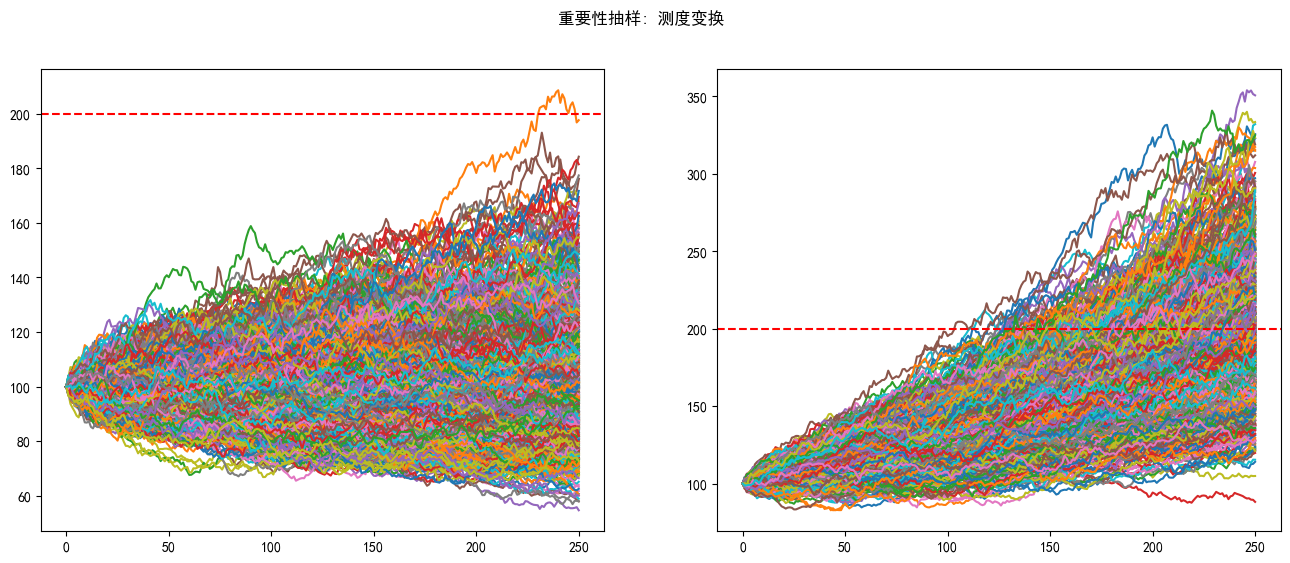

In [8]:
S0 = 100  # 标的价格
K = 200  # 行权价，因此为深度虚值期权
path_1 = geo_brownian(steps=250, paths=1000, T=1, S0=100, sigma=0.2, b=0.03)
path_2 = geo_brownian(steps=250, paths=1000, T=1, S0=100, sigma=0.2, b=np.log(K / S0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("重要性抽样: 测度变换")
ax1.plot(path_1)
ax1.axhline(y=K, c="r", ls="--")

ax2.plot(path_2)
ax2.axhline(y=K, c="r", ls="--")
plt.show()

In [9]:
#定义重要性抽样函数
def importance_sample(steps, paths, T, S0, K, sigma, r, b, new_b):
    """
    b代表原始的漂移率
    new_b代表测度变换后的漂移率
    """
    dt = T / steps  # 求出dt
    S_path = np.zeros((steps + 1, paths))  # 创建一个矩阵，用来准备储存模拟情况
    S_path[0] = S0  # 起点设置

    mu_t = (b - 0.5 * sigma**2) * dt  # 每一个原始测度dt的期望
    new_mu_t = (new_b - 0.5 * sigma**2) * dt  # 每一个测度变化后dt的期望
    sigma_t = sigma * np.sqrt(dt)  # 每一个dt的标准差
    px = stats.norm(mu_t, sigma_t)  # 原始概率密度
    qx = stats.norm(new_mu_t, sigma_t)  # 测度变换后的概率密度

    likelihood_ratio = 1  # likelihood_ratio是每次模拟的似然比，在循环中会每次累乘，最终计算结果为每条路径上的似然比
    for step in range(1, steps + 1): #模拟资产路径
        rn = np.random.standard_normal(paths)  # 创造随机数
        S_path[step] = S_path[step - 1] * np.exp(
            (new_b - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rn
        )  # 这里是重点，模拟用的漂移率是new_b
        likelihood_ratio = (
            likelihood_ratio
            * px.pdf(new_mu_t + rn * sigma_t)
            / qx.pdf(new_mu_t + rn * sigma_t)
        )  # 每次模拟的似然比累乘

    value = (
        np.exp(-r * T) * np.maximum(S_path[-1] - K, 0) * likelihood_ratio
    )  # 计算价值时，需要在每条路径上乘以似然比
    return value.mean()


value_is = importance_sample(
    steps=250,
    paths=50000,
    T=1,
    S0=100,
    K=200,
    sigma=0.2,
    r=0.03,
    b=0.03,
    new_b=np.log(200 / 100),
)
print(f"重要性抽样结果：{value_is:.6f}")
value_smc = MC(steps=250, paths=50000, T=1, S0=100, K=200, sigma=0.2, r=0.03, b=0.03)
print(f"标准蒙特卡洛模拟结果：{value_smc:.6f}")
value_bsm = BSM(CP="C", S=100, X=200, sigma=0.2, T=1, r=0.03, b=0.03)
print(f"解析解结果：{value_bsm:.6f}")

重要性抽样结果：0.003283
标准蒙特卡洛模拟结果：0.003923
解析解结果：0.003325
